<a href="https://colab.research.google.com/github/moArGit/adversarial-ml-pytorch/blob/main/security_intern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Adversarial Attacks and Defenses on Neural Networks**

*Adversarial attacks on neural networks have garnered significant attention due to their ability to deceive models with subtle, often imperceptible perturbations. Understanding these attacks and implementing effective defenses is crucial for developing robust AI systems*

In [1]:

# Note: For security, avoid hardcoding tokens. Consider using environment variables or manual input.
from getpass import getpass

# Prompt for PAT securely
token = getpass('Enter the GitHub Personal Access Token: ')

# Define repository URL
repo_url = f"https://{token}@github.com/moArGit/adversarial-ml-pytorch.git"

# Clone the repository
!git clone {repo_url}

Enter the GitHub Personal Access Token: ··········
Cloning into 'adversarial-ml-pytorch'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (11/11), 27.34 KiB | 6.84 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [2]:
%cd adversarial-ml-pytorch


/content/adversarial-ml-pytorch


###Install Necessary Libraries:

In [3]:
!pip install torch torchvision
!pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

## **Building a Neural Network Model**

### Import Libraries:

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

### Load and Preprocess Data:

In [5]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load training and test datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 503kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.83MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Define the CNN Model:

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Initialize Model, Loss Function, and Optimizer:

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Train the Model:

In [8]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")

Epoch [1/5], Loss: 0.1762, Accuracy: 94.67%
Epoch [2/5], Loss: 0.0564, Accuracy: 98.30%
Epoch [3/5], Loss: 0.0405, Accuracy: 98.72%
Epoch [4/5], Loss: 0.0311, Accuracy: 99.02%
Epoch [5/5], Loss: 0.0245, Accuracy: 99.21%


### Evaluate on Test Data:

In [9]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100*correct/total:.2f}%")

Test Accuracy: 98.99%


## **Implementing Adversarial Attacks**

## Fast Gradient Sign Method (FGSM)

### Define FGSM Attack Function:

In [10]:
def fgsm_attack(model, loss_fn, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    model.zero_grad()
    loss.backward()
    data_grad = images.grad.data
    sign_data_grad = data_grad.sign()
    perturbed_image = images + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

### Generate Adversarial Examples and Evaluate:

In [11]:
epsilon = 0.1  # Perturbation magnitude
correct = 0
adv_examples = []

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    perturbed_data = fgsm_attack(model, criterion, images, labels, epsilon)
    outputs = model(perturbed_data)
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).sum().item()

final_acc = correct / len(test_loader.dataset)
print(f"Test Accuracy under FGSM Attack (ε={epsilon}): {100*final_acc:.2f}%")

Test Accuracy under FGSM Attack (ε=0.1): 89.04%


## *Projected Gradient Descent (PGD)*

## Define PGD Attack Function:

In [12]:
def pgd_attack(model, loss_fn, images, labels, epsilon, alpha, iters):
    ori_images = images.data.clone().detach()

    for i in range(iters):
        images.requires_grad = True
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        model.zero_grad()
        loss.backward()
        data_grad = images.grad.data
        adv_images = images + alpha * data_grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-epsilon, max=epsilon)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()

    return images

## Generate Adversarial Examples and Evaluate:

In [13]:
epsilon = 0.3
alpha = 0.01
iters = 40
correct = 0

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    perturbed_data = pgd_attack(model, criterion, images, labels, epsilon, alpha, iters)
    outputs = model(perturbed_data)
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).sum().item()

final_acc = correct / len(test_loader.dataset)
print(f"Test Accuracy under PGD Attack (ε={epsilon}): {100*final_acc:.2f}%")

Test Accuracy under PGD Attack (ε=0.3): 45.18%


## **Implementing Defense Mechanisms**

## *Adversarial Training*

### Modify Training Loop to Include Adversarial Examples:

In [14]:
def train_adversarial(model, train_loader, optimizer, loss_fn, device, epsilon):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Generate adversarial examples
        perturbed_data = fgsm_attack(model, loss_fn, images, labels, epsilon)

        # Combine original and adversarial data
        combined_data = torch.cat([images, perturbed_data], dim=0)
        combined_labels = torch.cat([labels, labels], dim=0)

        # Forward pass
        outputs = model(combined_data)
        loss = loss_fn(outputs, combined_labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

### Re-Train the Model with Adversarial Training:

In [15]:
num_epochs = 5
epsilon = 0.1

for epoch in range(num_epochs):
    train_adversarial(model, train_loader, optimizer, criterion, device, epsilon)
    # Evaluate on clean data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {100*correct/total:.2f}%")

Epoch [1/5], Test Accuracy: 99.13%
Epoch [2/5], Test Accuracy: 99.14%
Epoch [3/5], Test Accuracy: 99.21%
Epoch [4/5], Test Accuracy: 99.08%
Epoch [5/5], Test Accuracy: 99.29%


## *Defensive Distillation*

### Define Function to Apply Softmax with Temperature:

In [16]:
def softmax_with_temperature(logits, temperature):
    return nn.functional.softmax(logits / temperature, dim=1)

### Train Distilled Model:

In [17]:
temperature = 20

class DistilledCNN(SimpleCNN):
    def forward(self, x):
        logits = super(DistilledCNN, self).forward(x)
        return softmax_with_temperature(logits, temperature)

distilled_model = DistilledCNN().to(device)
optimizer_distill = optim.Adam(distilled_model.parameters(), lr=0.001)
criterion_distill = nn.KLDivLoss(reduction='batchmean')

num_epochs = 5

distilled_model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer_distill.zero_grad()
        outputs = distilled_model(images)
        with torch.no_grad():
            teacher_outputs = model(images)
        targets = softmax_with_temperature(teacher_outputs, temperature)
        loss = criterion_distill(torch.log(outputs + 1e-10), targets)
        loss.backward()
        optimizer_distill.step()

        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    print(f"Distilled Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Distilled Epoch [1/5], Loss: 0.0571
Distilled Epoch [2/5], Loss: 0.0268
Distilled Epoch [3/5], Loss: 0.0238
Distilled Epoch [4/5], Loss: 0.0223
Distilled Epoch [5/5], Loss: 0.0214


### Evaluate Distilled Model:

In [18]:
distilled_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = distilled_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Distilled Model Test Accuracy: {100*correct/total:.2f}%")

Distilled Model Test Accuracy: 98.97%


## **Evaluating Model Robustness**

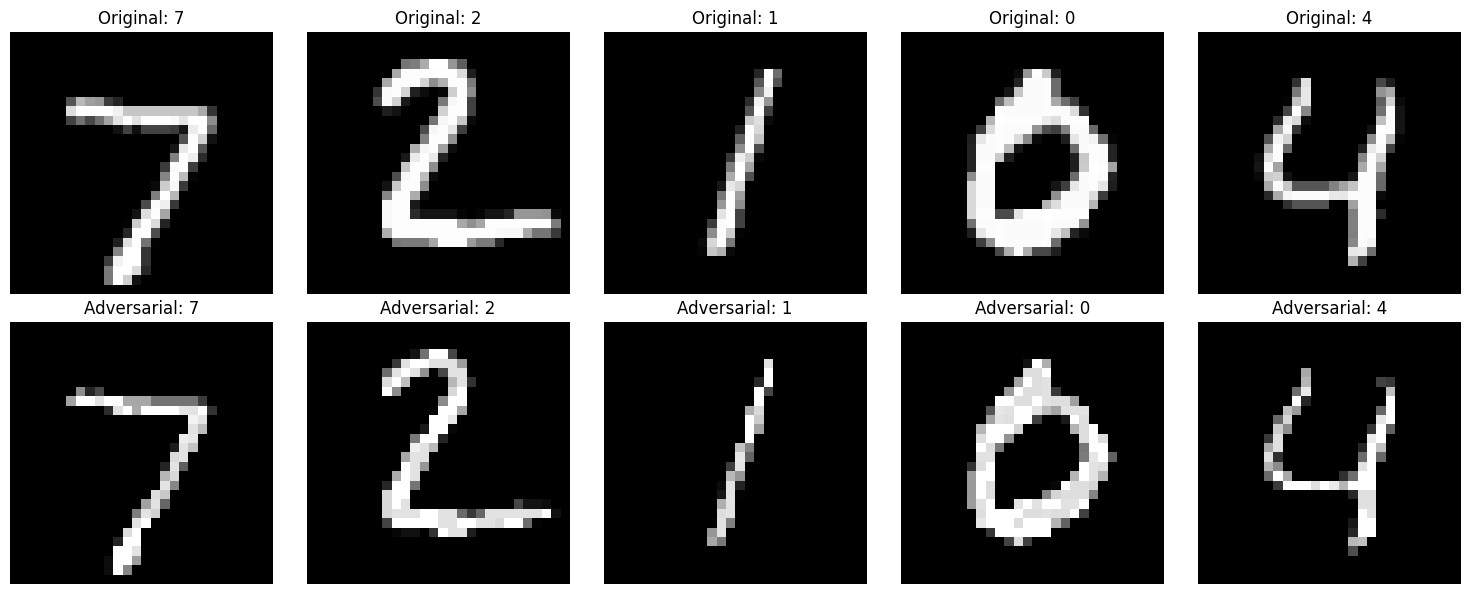

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title=None):
    """
    Display a single image.

    Args:
        img (torch.Tensor): Image tensor to display.
        title (str, optional): Title for the image. Defaults to None.
    """
    # Detach the tensor, move to CPU, and convert to NumPy
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Get a batch of test images
dataiter = iter(test_loader)

try:
    # Use the built-in next() function instead of dataiter.next()
    images, labels = next(dataiter)
except StopIteration:
    # In case the DataLoader is exhausted, reinitialize the iterator
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

# Move images and labels to the appropriate device
images, labels = images.to(device), labels.to(device)

# Generate adversarial examples using FGSM
epsilon = 0.1  # Perturbation magnitude
perturbed_data = fgsm_attack(model, criterion, images, labels, epsilon)

# Plot original and adversarial images side by side
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

for i in range(5):
    # Original Images
    ax_orig = axes[0, i]
    img_orig = images[i].detach().cpu().squeeze().numpy()  # Detach before converting
    ax_orig.imshow(img_orig, cmap='gray')
    ax_orig.set_title(f"Original: {labels[i].item()}")
    ax_orig.axis('off')

    # Adversarial Images
    ax_adv = axes[1, i]
    adv_img = perturbed_data[i].detach().cpu().squeeze().numpy()  # Detach before converting
    ax_adv.imshow(adv_img, cmap='gray')
    ax_adv.set_title(f"Adversarial: {labels[i].item()}")
    ax_adv.axis('off')

# Improve layout and display the plot
plt.tight_layout()
plt.show()